# ANALYSING SLEEP EEG DATA
### Anne Schlecht, 5795927

In [1]:
# import libraries
import mne
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yasa
from scipy.special import erf
mne.set_log_level('ERROR')
%matplotlib qt



# Loading the data

In [2]:
# set directory
dir = '/Users/Anne/Neuromodulation_Neuroplasticity/Tutorials/DATA/' # modify 

# Get all .fif files in directory
# (fractal image )
files = os.listdir(dir)
filename = [f for f in files if f.endswith('.fif')]

print('The filenames are:')
filename

The filenames are:


['example_controledf-raw.fif',
 '1-raw.fif',
 'example_MBIedf-raw.fif',
 '1-epo.fif']

The files 'example_MBIedf-raw.fif' (1), 'example_controledf-raw.fif' (2) and '1-raw.fif' (3) contain raw EEG data from nights that are associated with distinct interventions. Dataset (1) and (2) were acquired using a dry EEG system, omitting conductive gels (minimized setup time) and enabling at-home recording. While (1) involved a mindfulness-based intervention (MBI), (2) did not and serves as a control dataset. 

'1-raw.fif' contains raw EEG recordings from a night in the lab during which a subject was exposed to closed-loop neuromuscular stimulation (CL-NMES). The file '1-epo.fif' encompasses the same EEG data organized into epochs of xx ms length.

In [3]:
# load the raw data
raw_CLNMES = mne.io.read_raw_fif(dir + '1-raw.fif', preload = True)
raw_MBI = mne.io.read_raw_fif(dir + 'example_MBIedf-raw.fif', preload = True)
raw_control = mne.io.read_raw_fif(dir + 'example_controledf-raw.fif', preload = True)


# Pre-processing the data
**The provided data has already undergone pre-processing**.  

To get a feel for the data, retrieve **all available metadata** for the given recordings using the info function.

### CL-NMES recordings

In [4]:
# data from CL-NMES intervention (lab)
info_CLNMES = raw_CLNMES.info
info_CLNMES
print('The current sampling frequency is', info_CLNMES['sfreq'], 'Hz')
# show channel names
print(raw_CLNMES.ch_names)

# data shape:
print(raw_CLNMES.get_data().shape)

raw_CLNMES


The current sampling frequency is 128.0 Hz
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CPz', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'ECG', 'EDC', 'EOG', 'EMG_L', 'EMG_R']
(69, 1024775)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,"64 EEG, 1 ECG, 3 EMG, 1 EOG"
Bad channels,None
EOG channels,EOG
ECG channels,ECG
Sampling frequency,128.00 Hz
Highpass,0.50 Hz
Lowpass,30.00 Hz


- Metainformation (e.g. measurement date, participant details) are not available.
- For the CL-NMES intervention, 67 channels were used for recording.  
- The data from thehas been resampled with a frequency of 128 Hz and (FIXME-> ask Michael)  probably band-passed filtered for a frequency range from 0.5 Hz to 30 Hz. Thus, there should be not gamma oscillations (or higher frequencies) present in the EEG data.

In [57]:
# select (pre-)frontal channels + motor cortex
lab_eeg_chans = ['Fp1', 'Fp2', 'Fpz', 'FC5', 'FC1','FC2','FC6']

# channels from pre-frontal cortex
lab_prefrontal_channels = ['Fp1', 'Fpz', 'Fp2'];

# channels above the motor cortex
lab_motorc_channels = ['FC1','FC2','FC6'];

# sampling frequency for lab data
lab_sf = raw_CLNMES.info['sfreq'] #128 Hz

### At-home recordings

In [6]:
# metadata for at-home recordings
raw_MBI.info

Measurement date,"November 22, 2023 23:09:06 GMT"
Experimenter,Unknown
Participant,Aaron_Birk
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.50 Hz
Lowpass,30.00 Hz


- Metainformation is partially available.
- For the at-home recordings, the dry EEG system obtained data from 8 electrodes.


In [7]:
# channel names for at-home recordings
print('The channel names in the at-home recordings are:', raw_MBI.ch_names)

The channel names in the at-home recordings are: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'Fpz', 'M2']


In [8]:
# get all relevant metadata for computing the relative spectral power values
# slow waves are more probable in frontal areas -> includes these channels
dry_eeg_chans = ['Fp1', 'Fp2', 'F3', 'F4', 'Fpz']

# sampling frequency for dry EEG data is 100 Hz
dryEEG_sf = raw_MBI.info['sfreq']
#dryEEG_sf

# Section 0

## (a)
Utilize the **automated sleep stage classification** algorithm from the YASA toolbox to get predicted sleep stages. Use the relevant metadata if available.

In [9]:
# yasa sleep stage classification algo requires lightgbm + antropy packages

# I hit the error "OSError: libgomp.so.1: cannot open shared object file: No such file or director" -> thus
# the OpenMPI library is required for running LIGHTGBM on macOS: 
#   brew install libomp
# then: conda install -n sleep_analysis lightgbm 
import lightgbm

# AntroPy package (used to extract features from EEG signals)
# conda config --add channels conda-forge
# conda config --set channel_priority strict
# conda install -n sleep_analysis antropy
import antropy

In [10]:
# change plotting style
%matplotlib inline

/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


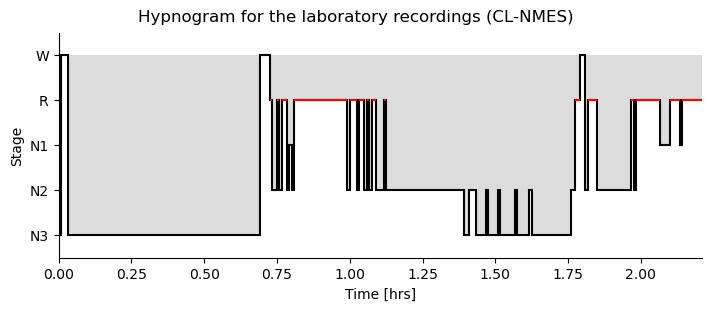

In [11]:
# information about age and sex is not available -> use algorithm without specifying metadata (will still be accurate enough)

# Sleep staging object intialization
sls_CLNMES = yasa.SleepStaging(raw_CLNMES, eeg_name="Fz", eog_name="EOG",
                        emg_name="EMG_L") #FIXME: EMG_L or _R

#  Get the predicted sleep stages (for each 30-sec epoch of the data) on Fz
hypno_CLNMES = yasa.hypno_str_to_int(sls_CLNMES.predict())  

# plot the hypnogram
fig, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True)
fig.suptitle('Hypnogram for the laboratory recordings (CL-NMES)')
ax = yasa.plot_hypnogram(hypno_CLNMES, fill_color = "gainsboro")


The dataset from the CL-NMES intervention provides us with data from 2 hours of sleeping time. It seems as if the subject went straight from an "awake" state to a non-REM sleep of stage 3 (slow-wave sleep, deepest stage of sleep). 
**FIXME more**

<Axes: xlabel='Time (30-sec epoch)', ylabel='Probability'>

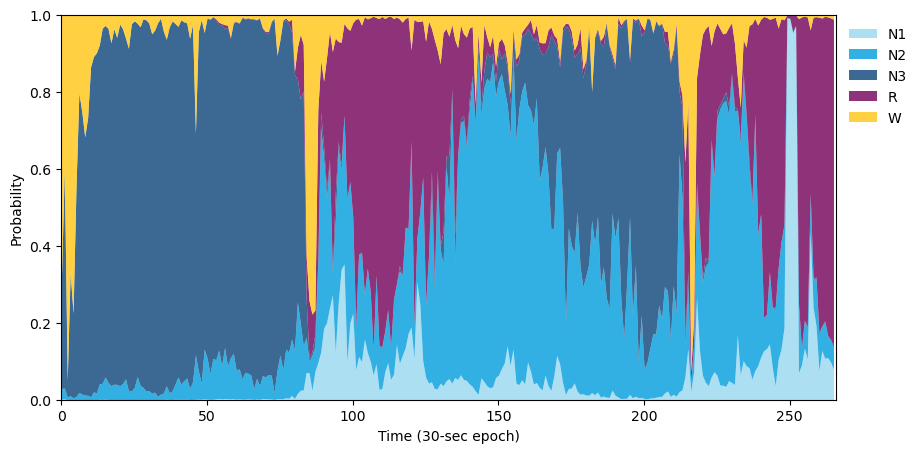

In [12]:
# get the predicted probabilities
proba_CLNMES = sls_CLNMES.predict_proba()

# compute the confidence
confidence_CLNMES = proba_CLNMES.max(axis=1)
#print(sum(confidence < 0.5)) FIXME

# plot the predicted probabilities based on the model
sls_CLNMES.plot_predict_proba()

Do the same for the dry EEG system-based recordings (mindfulness-based intervention / control):

In [13]:
# show channel names
print('The channel names for the control night are:', raw_control.ch_names)

The channel names for the control night are: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'Fpz', 'M2']


/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


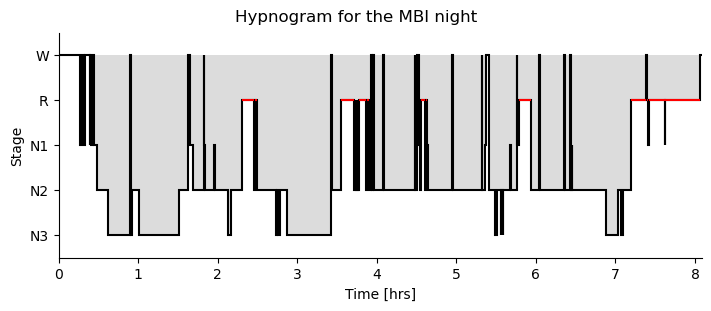

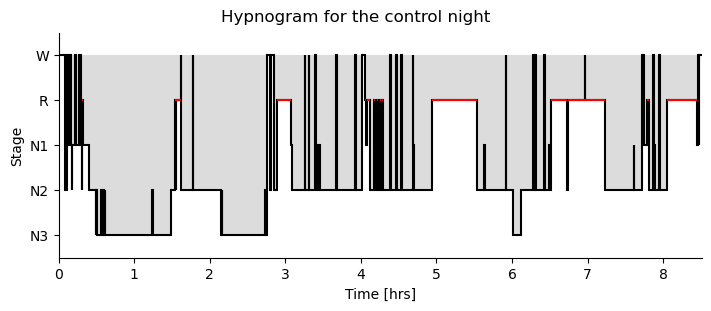

In [14]:
# Sleep staging object intialization, no metadata available, no EOG, no EMG
# -> hypnogram on Fpz
sls_MBI = yasa.SleepStaging(raw_MBI, eeg_name="Fpz")
sls_control = yasa.SleepStaging(raw_control, eeg_name="Fpz")

# Get the predicted sleep stages
hypno_MBI = yasa.hypno_str_to_int(sls_MBI.predict())     
hypno_control = yasa.hypno_str_to_int(sls_control.predict()) 

# plot the hypnograms
#fig, ax1 = plt.subplots(1,1, figsize = (7,3))
fig, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True)
ax = yasa.plot_hypnogram(hypno_MBI, fill_color = "gainsboro")
fig.suptitle('Hypnogram for the MBI night')

fig, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True)
ax = yasa.plot_hypnogram(hypno_control, fill_color = "gainsboro")
fig.suptitle('Hypnogram for the control night');


By visual inspection, it seems as if the subject woke up very frequently during both the MBI and the control night. However, during the control night in which the subject did not used mindfulness practice, it seems as if the subject woke up even more. This suggests that the mindfulness intervention might be effectively reducing disrupted sleep.

Deep sleep occurred predominantly (with interruptions) during the first 3/3.5 hours of the total sleeping time.

These preliminary visual observations are further explored in the next section (b).

## (b) 
Extract the sleep statistics for the **dry EEG system-based recordings** and compare the
results between the night with meditation and the audiobook control.

In [15]:
# extract the sleep statistics (expressed in minutes) based on hypnogram

# the sleep stage classification algo classifies epochs of 30 sec length -> 
#       sampling frequency of the hypnogram is 30 Hz 
sleepStats_MBI = yasa.sleep_statistics(hypno_MBI, sf_hyp = 1/30);
sleepStats_control = yasa.sleep_statistics(hypno_control, sf_hyp = 1/30);

### Qualitative comparision of the sleeping statistics obtained from the at-home recordings

In [16]:
# total sleep time 
print(sleepStats_MBI['TST']) 
print(sleepStats_control['TST'])

# slow-wave sleep in percentages of TST 
print(sleepStats_MBI['%N3']) # ≈ 21.98%
print(sleepStats_control['%N3']) # ≈ 20.31%
# -> slightly more deep sleep in MBI condition

# sleep efficiency seems comparable 
print(sleepStats_MBI['SE']) # ≈ 92%
print(sleepStats_control['SE']) # ≈ 94%

# sleep onset latency
print(sleepStats_MBI['SOL']) # -> unexpectably: high latency to first epoch of any sleep
print(sleepStats_control['SOL'])


448.0
480.0
21.986607142857142
20.3125
92.27600411946447
93.9334637964775
17.0
6.0


Surprisingly, the subject fell asleep later in the night that involved the mindfulness-based intervention.

In [17]:
# the relative duration of slow-wave (stage 3) sleep does not seem to differ much (naive comparision)
print('%N3 MBI:', sleepStats_MBI['%N3'])
print('%N3 control: ', sleepStats_control['%N3'])

%N3 MBI: 21.986607142857142
%N3 control:  20.3125


In [18]:
# inspect the duration of wake periods (in minutes) for the MBI and control night
print('Longer duration of wakefulness during the control night? ->', 
      sleepStats_MBI['WASO'] < sleepStats_control['WASO'], '(', sleepStats_MBI['WASO'], '<', sleepStats_control['WASO'], ')')

# relative duration of stage 2 sleep: 
print('Longer duration (realtive to TOT) of stage 2 sleep in MBI night? ->', 
      sleepStats_MBI['%N2'] > sleepStats_control['%N2'])

Longer duration of wakefulness during the control night? -> True ( 19.5 < 23.0 )
Longer duration (realtive to TOT) of stage 2 sleep in MBI night? -> True


By "casual" inspection, it appears that the subject spent a relatively greater amount of time in stage 2 of non-REM sleep in the night preceeded by mindfulness practice. Given that spindles predominantly occur during this stage, it might be interesting to explore whether there is an increased occurence of spindle activity in the MBI night.

In [19]:
# FIXME: optionally extract the transition matrix

# Section 1: Power Analysis in Sleep Stages

# (a)
Segment data into **30 second epochs** with MNE.

In [20]:
# Epoch lab data into 30s segments
epochs_CLNMES = mne.make_fixed_length_epochs(raw_CLNMES, duration=30, preload=True, verbose=False)

# Add the sleep stages to the epochs
epochs_CLNMES.events[:, 2] = hypno_CLNMES

In [21]:
# do the same for at-home recordings
epochs_MBI = mne.make_fixed_length_epochs(raw_MBI, duration=30, preload=True, verbose=False)
epochs_control = mne.make_fixed_length_epochs(raw_control, duration=30, preload=True, verbose=False)

# Add the sleep stages to the epochs
epochs_MBI.events[:, 2] = hypno_MBI
epochs_control.events[:, 2] = hypno_control

# (b)
Compare the **power spectra** between mindfulness intervention and control nights.

In [22]:
# extract the frequency bands of interest from the power spectral density
freq_bands = [(0.5, 4, "Delta"), (4, 8, "Theta"), (8, 12, "Alpha"), (12, 16, "Sigma"),
              (16, 30, "Beta"), (30, 40, "Gamma")]
band_names = ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma'];

## CL-NMES recordings

/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


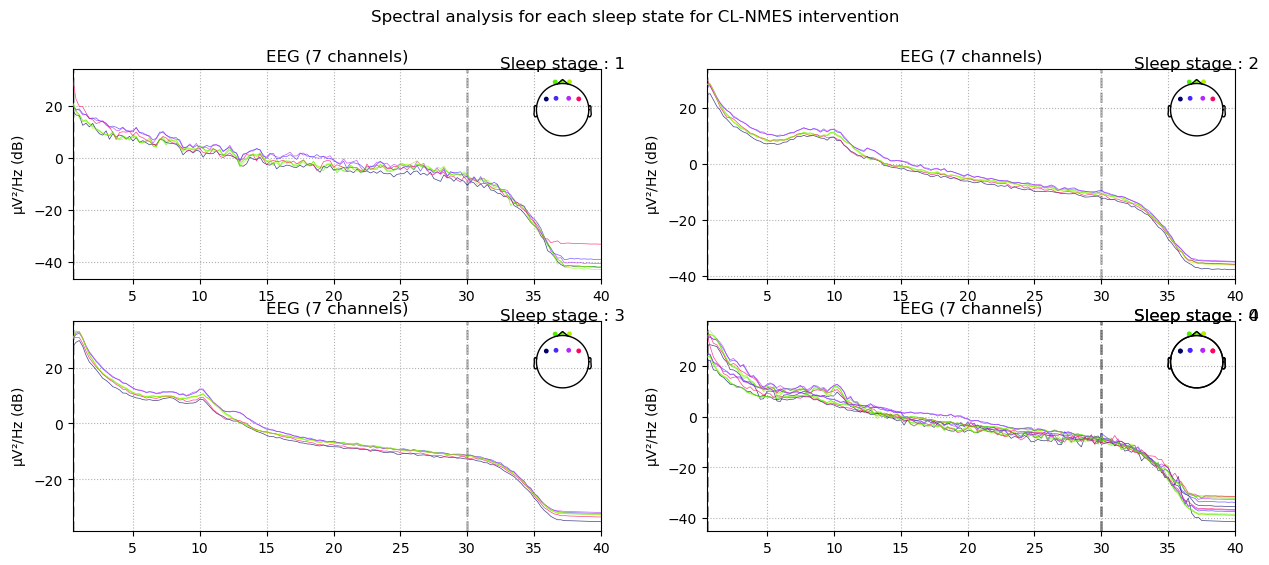

In [23]:
# spectral analysis for the lab data (CL-NMES intervention)

# plot the power spectral density for each sleep stage 
power_CLNMES = []
ax, fig = plt.subplots(2, 2, figsize=(15, 6));
fig = fig.flatten(); # enable 1D access
for stage in np.unique(hypno_CLNMES): 
    epochs_stage = epochs_CLNMES[epochs_CLNMES.events[:, 2] == stage];
    # perform spectral analysis on epochs of observed state
    psd_CLNMES = epochs_stage.compute_psd(method="welch", 
                                   fmin=0.5,
                                   fmax=40,
                                   picks=lab_eeg_chans,
                                   n_jobs=-1,
                                   **dict(average='median', n_fft=int((2/0.5)*lab_sf)));
    # compute average power in the specified frequency bands freq_bands
    rel_power = yasa.bandpower_from_psd(psd=psd_CLNMES._data.mean(0), 
                                        freqs=psd_CLNMES.freqs,
                                        #ch_names=psd.ch_names, 
                                        bands=freq_bands,  relative=True); # get the relative spectral power values 
    psd_CLNMES.plot(average=False, axes = fig[stage-1]);

    #psd_MBI.plot(average=False)
    rel_power['Stage'] = stage;
    power_CLNMES.append(rel_power);
    plt.title(f'Sleep stage : {stage}');
    
    plt.suptitle('Spectral analysis for each sleep state for CL-NMES intervention');

## At-home recordings

/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


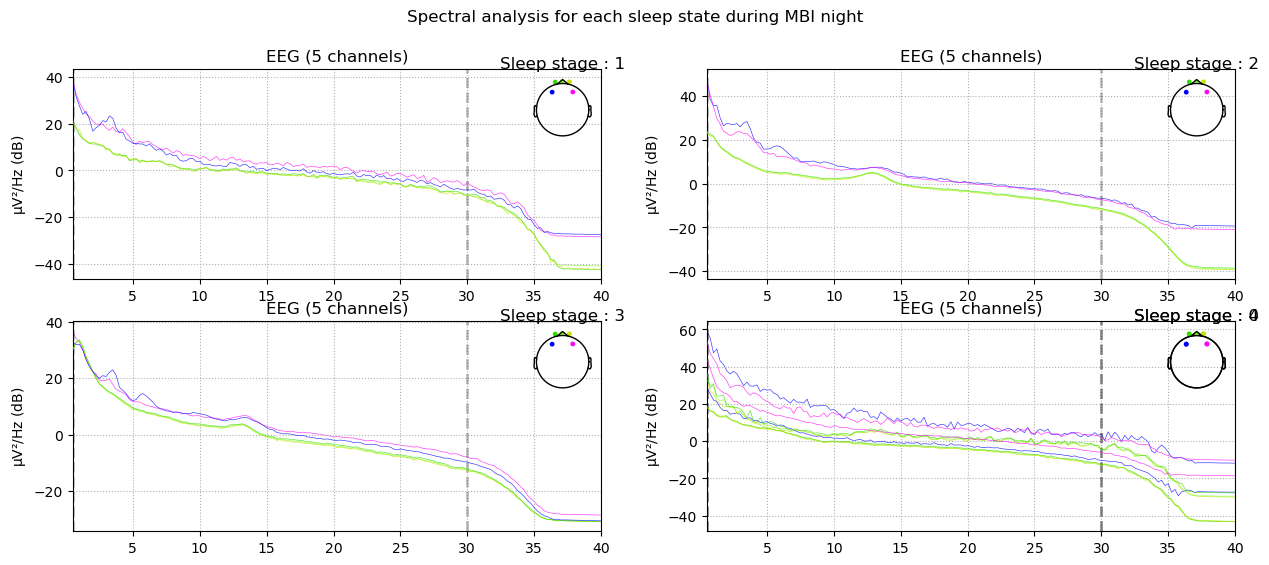

In [24]:
# Mindfulness-based intervention

# plot the power spectral density for each sleep stage 
power_MBI = []
ax, fig = plt.subplots(2, 2, figsize=(15, 6))
fig = fig.flatten() # enable 1D access
for stage in np.unique(hypno_MBI):
    epochs_stage = epochs_MBI[epochs_MBI.events[:, 2] == stage]
    # perform spectral analysis on epochs of observed state
    psd_MBI = epochs_stage.compute_psd(method="welch", 
                                   fmin=0.5,
                                   fmax=40,
                                   picks=dry_eeg_chans,
                                   n_jobs=-1,
                                   **dict(average='median', n_fft=int((2/0.5)*dryEEG_sf)))
    rel_power = yasa.bandpower_from_psd(psd=psd_MBI._data.mean(0), 
                                        freqs=psd_MBI.freqs,
                                        #ch_names=psd.ch_names, 
                                        bands= freq_bands,
                                        relative=True) # get the relative spectral power values 
    psd_MBI.plot(average=False, axes = fig[stage-1])

    #psd_MBI.plot(average=False)
    rel_power['Stage'] = stage
    power_MBI.append(rel_power)
    plt.title(f'Sleep stage : {stage}')
    
    plt.suptitle('Spectral analysis for each sleep state during MBI night');
    

/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


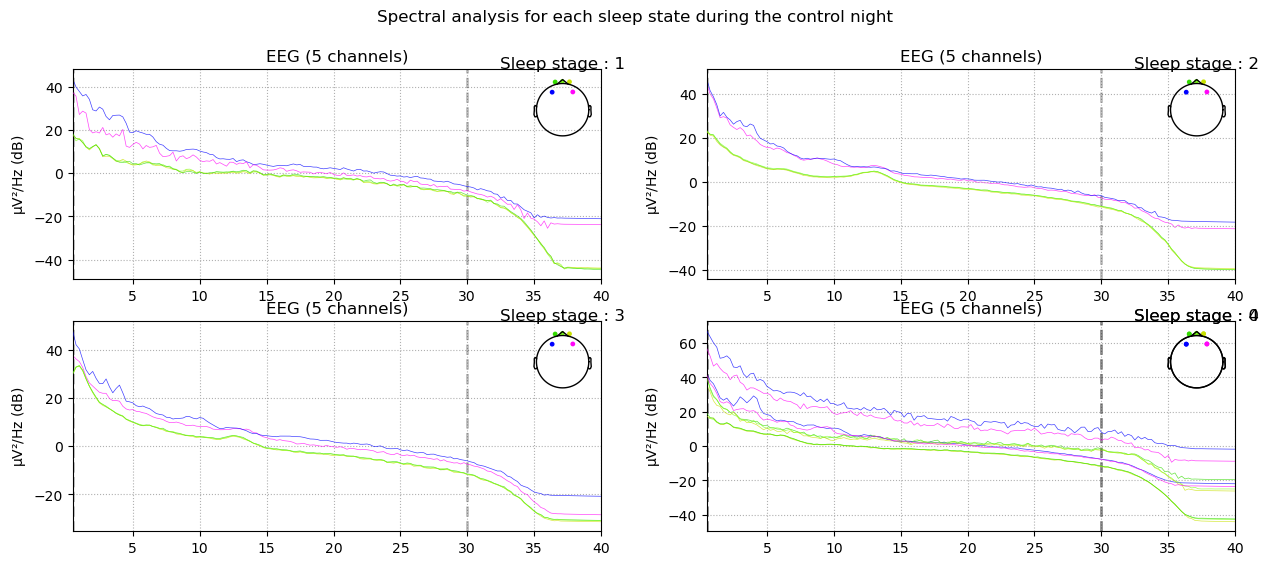

In [25]:
# do the same for the control night

# plot the power spectral density for each sleep stage 
power_control = [];
ax, fig = plt.subplots(2, 2, figsize=(15, 6));
fig = fig.flatten(); # enable 1D access
for stage in np.unique(hypno_control):
    epochs_stage = epochs_control[epochs_control.events[:, 2] == stage];
    # perform spectral analysis on epochs of observed state
    psd_control = epochs_stage.compute_psd(method="welch", 
                                   fmin=0.5,
                                   fmax=40,
                                   picks=dry_eeg_chans,
                                   n_jobs=-1,
                                   **dict(average='median', n_fft=int((2/0.5)*dryEEG_sf)));
    rel_power = yasa.bandpower_from_psd(psd=psd_control._data.mean(0), 
                                        freqs=psd_control.freqs,
                                        #ch_names=psd.ch_names, 
                                        # extract the frequency bands of interest from the power spectral density
                                        bands= freq_bands,
                                        relative=True); # get the relative spectral power values 
    psd_control.plot(average=False, axes = fig[stage-1]);

    #psd_MBI.plot(average=False)
    rel_power['Stage'] = stage;
    power_control.append(rel_power);
    plt.title(f'Sleep stage : {stage}');
    
    plt.suptitle('Spectral analysis for each sleep state during the control night');

In [26]:
# relative power as a dataframe
power_MBI_df = pd.concat(power_MBI).reset_index(drop=True)
power_control_df = pd.concat(power_control).reset_index(drop=True)

# add column to each dataframe specifying the data structure
power_control_df['Data Source'] = 'Control'
power_MBI_df['Data Source'] = 'MBI'

# concatenate the two dataframes
df_combined = pd.concat([power_control_df, power_MBI_df])

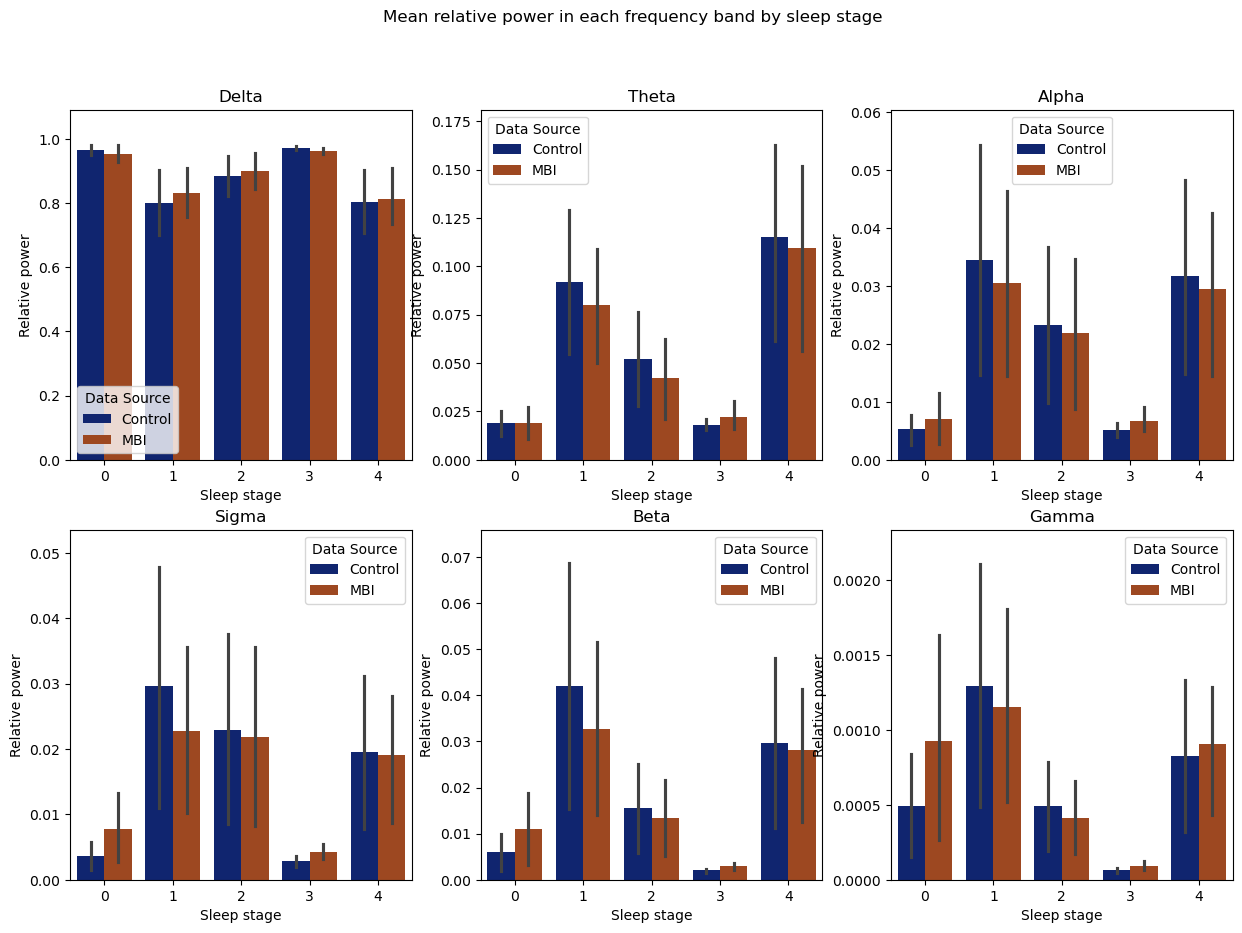

In [27]:
# Plot the mean relative power in each frequency band by sleep stage 
ax, fig = plt.subplots(2, 3, figsize=(15, 10))
fig = fig.flatten()
for i, band in enumerate(['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']):
    df_ = df_combined[['Stage', band, 'Data Source']]
    sns.barplot(data = df_, x='Stage', y=band, hue="Data Source", palette = 'dark', ax=fig[i]) 
    fig[i].set_title(band)
    fig[i].set_xlabel('Sleep stage')
    fig[i].set_ylabel('Relative power')
    fig[i].set_ylim(0, np.percentile(df_[band], 99)*1.1)
#plt.tight_layout()
plt.suptitle('Mean relative power in each frequency band by sleep stage');


Upon visual inspection, the mean relative power in each frequency band does differ in the MBI and the control night.

## (c)
Visualize the **power spectra differences** across stages in all 3 nights.

In [29]:
# Compute the difference between averaged data for each sleep stage
diff = pd.DataFrame(columns=['Stage'] + band_names); # intitialise
for stage in np.unique(hypno_MBI):
    MBI_thisStage = power_MBI_df[power_MBI_df['Stage'] == stage];
    control_thisStage = power_control_df[power_MBI_df['Stage'] == stage];

    # average the power densities for all frequency bands
    MBI_sls_avg = MBI_thisStage[band_names].mean();
    control_sls_avg = control_thisStage[band_names].mean();
    di = pd.DataFrame((MBI_sls_avg.values - control_sls_avg.values)).T;
    di.columns = band_names;
    di['Stage'] = stage ;
    # insert
    diff = pd.concat([diff, di], ignore_index=True)
diff;

/var/folders/_s/8q5tfyq977g3pp8gp371jhwm0000gn/T/ipykernel_1529/2440233121.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  diff = pd.concat([diff, di], ignore_index=True)


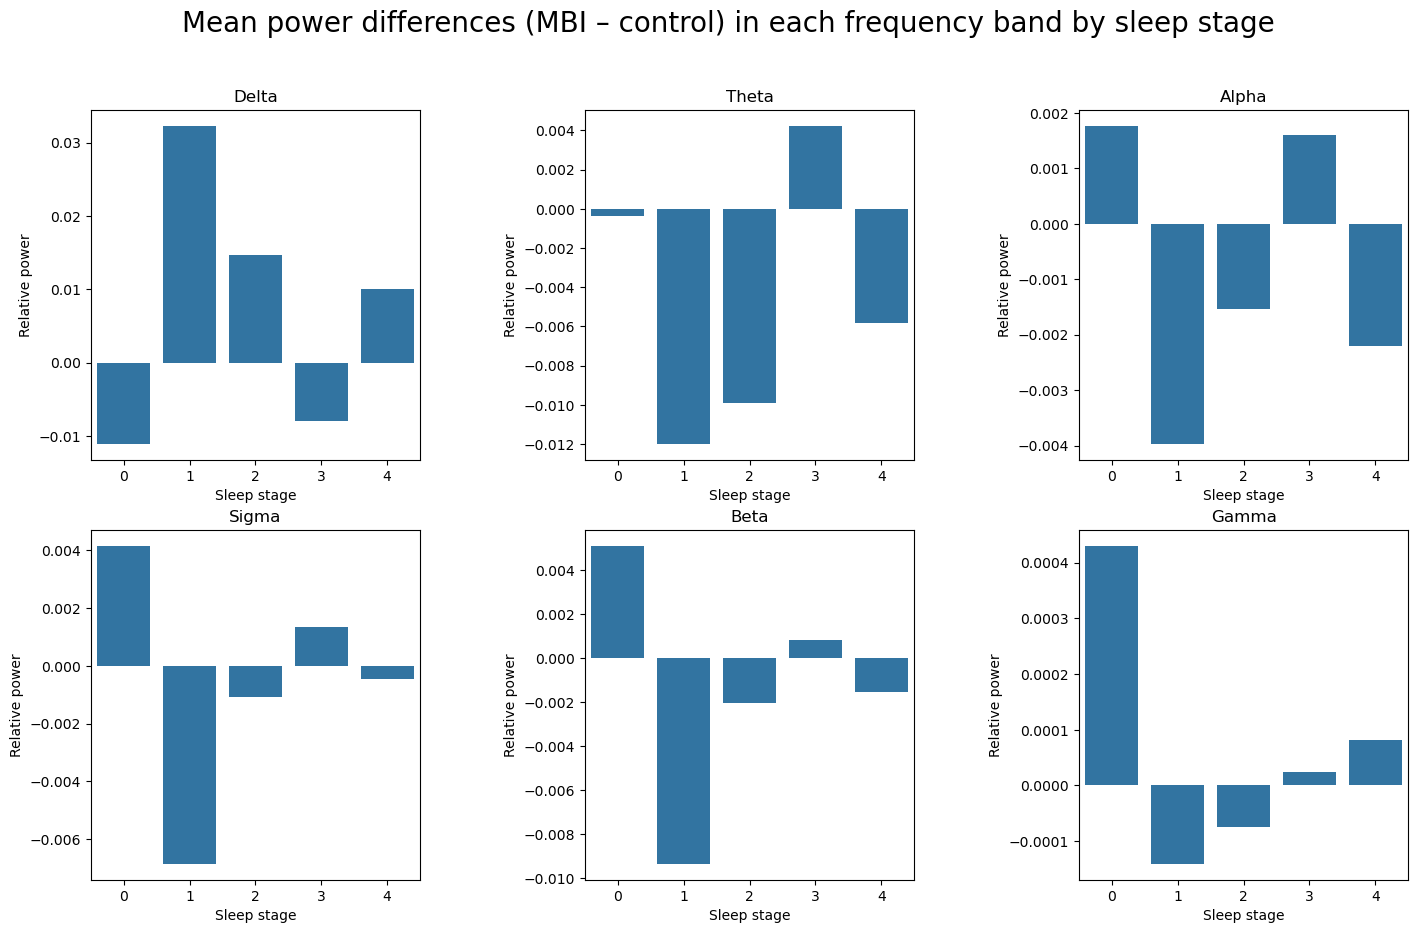

In [30]:
# Plot the mean relative power in each frequency band by sleep stage 
ax, fig = plt.subplots(2, 3, figsize=(17, 10))
plt.subplots_adjust(wspace=0.5); # increase margin between figures
fig = fig.flatten()
for i, band in enumerate(['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']):
    sns.barplot(data = diff, x='Stage', y=band, ax=fig[i]) 
    fig[i].set_title(band)
    fig[i].set_xlabel('Sleep stage')
    fig[i].set_ylabel('Relative power')
    
#plt.tight_layout()
plt.suptitle('Mean power differences (MBI – control) in each frequency band by sleep stage', fontsize =20);

# Section 2: Slow oscillations and spindle detection

## (a)
Identify **artifacts** and modify the hypnogram, accordingly.
How many **epochs were rejected in each dataset**? Is this more than expected given a normal distribution?

### Artifact rejection for CL-NMES recordings (covariance-based):

In [31]:
# Upsample hypnogram
new_hypno_CLNMES = yasa.hypno_upsample_to_data(hypno_CLNMES, sf_hypno=1/30, 
                                        data=raw_CLNMES, sf_data=lab_sf)

# Artifact detection based on covariance matrix
lab_art, lab_zscores = yasa.art_detect(raw_CLNMES.copy().pick(lab_eeg_chans), lab_sf, window=5, method='covar', threshold=3)
# entries in lab_art indicate whether corresponding epoch is good/bad
#

# Merge the artifact vector wiht the hypnogram, where the art resolution is 5s so 1/5 (= 0.2 Hz)
lab_sf_art = 1 / 5
art_up_CLNMES = yasa.hypno_upsample_to_data(lab_art, lab_sf_art, raw_CLNMES, lab_sf)

# modify the hypnogram: add -1 to hypnogram where artifacts were detected
hypno_with_art_CLNMES = new_hypno_CLNMES
hypno_with_art_CLNMES[art_up_CLNMES] = -1

19-Dec-23 10:27:46 | WARNING | Hypnogram is SHORTER than data by 26.05 seconds. Padding hypnogram with last value to match data.size.
19-Dec-23 10:27:48 | WARNING | Hypnogram is SHORTER than data by 1.05 seconds. Padding hypnogram with last value to match data.size.


In [32]:
# valid range: within +-3 std away from the mean
threshold = 3
# expected proportion of samples outside the range
perc_expected_rejected = (1 - erf(threshold / np.sqrt(2))) * 100
print(f'{perc_expected_rejected:.2f}% of all epochs are expected to be rejected.')

# percentage of epochs that are actually rejected
(lab_art.sum() / lab_art.size) * 100
print(f'{(lab_art.sum() / lab_art.size) * 100:.2f}% of all epochs were actually rejected.')

0.27% of all epochs are expected to be rejected.
0.19% of all epochs were actually rejected.


For the lab recordings, the number of samples was rejected is lower than expected (assuming a normal distribution).

/var/folders/_s/8q5tfyq977g3pp8gp371jhwm0000gn/T/ipykernel_1529/3839233255.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lab_zscores)


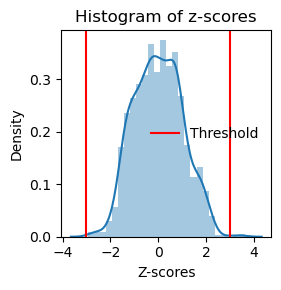

In [33]:
# plot the distribution of z-scores for 
plt.subplots(1,1,figsize=(3,3))
sns.distplot(lab_zscores)
plt.title('Histogram of z-scores')
plt.xlabel('Z-scores')
plt.ylabel('Density')
plt.axvline(3, color='r', label='Threshold')
plt.axvline(-3, color='r')
plt.legend(frameon=False);
plt.tight_layout()

### Artifact rejection for the at-home recordings

In [34]:
# Upsample hypnograms
new_hypno_MBI = yasa.hypno_upsample_to_data(hypno_MBI, sf_hypno=1/30, 
                                        data=raw_MBI, sf_data=dryEEG_sf)
new_hypno_control = yasa.hypno_upsample_to_data(hypno_control, sf_hypno=1/30, 
                                        data=raw_control, sf_data=dryEEG_sf)

# Artifact detection based on covariance matrix 
thresh = 3
MBI_art, _ = yasa.art_detect(raw_MBI.copy().pick(dry_eeg_chans), dryEEG_sf, window=5, method='covar', threshold=thresh)
# entries in MBI_art indicate whether corresponding epoch is good/bad
control_art, _ = yasa.art_detect(raw_control.copy().pick(dry_eeg_chans), dryEEG_sf, window=5, method='covar', threshold=thresh)

# Merge the artifact vector wiht the hypnogram, where the art resolution is 5s so 1/5 (= 0.2 Hz)
sf_art = 1 / 5
art_up_MBI = yasa.hypno_upsample_to_data(MBI_art, sf_art, raw_MBI, dryEEG_sf)
art_up_control = yasa.hypno_upsample_to_data(control_art, sf_art, raw_control, dryEEG_sf)

# modify the hypnogram: add -1 to hypnogram where artifacts were detected
hypno_with_art_MBI = new_hypno_MBI
hypno_with_art_MBI[art_up_MBI] = -1
hypno_with_art_control = new_hypno_control
hypno_with_art_control[art_up_control] = -1

19-Dec-23 10:27:48 | WARNING | Hypnogram is SHORTER than data by 6.00 seconds. Padding hypnogram with last value to match data.size.
19-Dec-23 10:27:48 | WARNING | Hypnogram is SHORTER than data by 1.00 seconds. Padding hypnogram with last value to match data.size.
19-Dec-23 10:28:00 | WARNING | Hypnogram is SHORTER than data by 1.00 seconds. Padding hypnogram with last value to match data.size.
19-Dec-23 10:28:00 | WARNING | Hypnogram is SHORTER than data by 1.00 seconds. Padding hypnogram with last value to match data.size.


In [35]:
# percentage of epochs that are expected to be rejected
perc_expected_rejected = (1 - erf(thresh / np.sqrt(2))) * 100
print(f'For each night {perc_expected_rejected:.2f}% of all epochs are expected to be rejected.')

# Print the percentage of epochs that are actually rejected
print(f'In the data that involved the mindfulness-based intervention {(MBI_art.sum() / MBI_art.size) * 100:.2f}% of all epochs were actually rejected.')
print(f'In the data that involved NO mindfulness-based intervention {(control_art.sum() / control_art.size) * 100:.2f}% of all epochs were actually rejected.')

For each night 0.27% of all epochs are expected to be rejected.
In the data that involved the mindfulness-based intervention 2.54% of all epochs were actually rejected.
In the data that involved NO mindfulness-based intervention 4.57% of all epochs were actually rejected.


For the at-home recordings, more samples had to be rejected than what is expected assuming a normal distribution.

# (b)
Implement **slow wave and spindle detection** for each continuous dataset.

### CL-NMES recordings

In [36]:
# detect slow waves
sw_CLNMES = yasa.sw_detect(raw_CLNMES.copy().pick(lab_eeg_chans), 
                    hypno=hypno_with_art_CLNMES,
                    include=(2, 3),
                    remove_outliers=True,
                    coupling=True,
                    coupling_params={"freq_sp": (12, 16), "time": 1, "p": 0.05},
                    )

# detect spindles
spindles_CLNMES = yasa.spindles_detect(raw_CLNMES.copy().pick(lab_eeg_chans),
                                hypno=hypno_with_art_CLNMES,
                                include=(2, 3),
                                freq_sp=(12, 16),
                                freq_broad=(1, 30),
                                duration=(0.5, 3),
                                remove_outliers=True,
                                )   

### At-home recordings

In [37]:
# MBI night
# detect slow waves
sw_MBI = yasa.sw_detect(raw_MBI.copy().pick(dry_eeg_chans), 
                    hypno=hypno_with_art_MBI,
                    include=(2, 3),
                    remove_outliers=True,
                    coupling=True,
                    coupling_params={"freq_sp": (12, 16), "time": 1, "p": 0.05},
                    )  
# detect spindles
spindles_MBI = yasa.spindles_detect(raw_MBI.copy().pick(dry_eeg_chans),
                                hypno=hypno_with_art_MBI,
                                include=(2, 3),
                                freq_sp=(12, 16),
                                freq_broad=(1, 30),
                                duration=(0.5, 3),
                                remove_outliers=True,
                                )         


In [38]:
# control night
# detect slow waves
sw_control = yasa.sw_detect(raw_control.copy().pick(dry_eeg_chans), 
                    hypno=hypno_with_art_control,
                    include=(2, 3),
                    remove_outliers=True,
                    coupling=True,
                    coupling_params={"freq_sp": (12, 16), "time": 1, "p": 0.05},
                    )  
# detect spindles
spindles_control = yasa.spindles_detect(raw_control.copy().pick(dry_eeg_chans),
                                hypno=hypno_with_art_control,
                                include=(2, 3),
                                freq_sp=(12, 16),
                                freq_broad=(1, 30),
                                duration=(0.5, 3),
                                remove_outliers=True,
                                ) 

# (c)
Analyze and compare the **frequency** and **duratio**n of SO and spindles between nights.

### At-home recordings

In [39]:
# slow waves

# average duration and frequency per channel + stage
MBI_results = sw_MBI.summary(grp_chan = True, grp_stage = True)[['Duration', 'Frequency']]
MBI_results['Data Source'] = 'MBI'
control_results = sw_control.summary(grp_chan = True, grp_stage = True)[['Duration', 'Frequency']]
control_results['Data Source'] = 'Control'

# compare mean duration of slow waves (avg over all channels + stages)
print(f"mean duration of slow waves during MBI night: {MBI_results['Duration'].mean():.2f} seconds")
print(f"mean duration of slow waves during control night: {control_results['Duration'].mean():.2f} seconds\n")

# average the frequency over all channels and stages too
print(f"avg freq of slow waves during MBI night: {MBI_results['Frequency'].mean():.2f} Hz")
print(f"avg freq of slow waves during control night: {control_results['Frequency'].mean():.2f} Hz\n")

# display more detailed summary
summary = MBI_results.align(control_results)
summary


mean duration of slow waves during MBI night: 1.17 seconds
mean duration of slow waves during control night: 1.14 seconds

avg freq of slow waves during MBI night: 0.89 Hz
avg freq of slow waves during control night: 0.91 Hz



(               Duration  Frequency Data Source
 Stage Channel                                 
 2     F3       1.247983   0.844503         MBI
       F4       1.362500   0.778542         MBI
       Fp1      1.202533   0.853218         MBI
       Fp2      1.203986   0.852465         MBI
       Fpz      1.212660   0.845677         MBI
 3     F3       1.110640   0.940407         MBI
       F4       1.147482   0.915638         MBI
       Fp1      1.070267   0.964963         MBI
       Fp2      1.089524   0.948699         MBI
       Fpz      1.077995   0.957041         MBI,
                Duration  Frequency Data Source
 Stage Channel                                 
 2     F3       1.215977   0.868099     Control
       F4       1.190335   0.881076     Control
       Fp1      1.187803   0.864508     Control
       Fp2      1.185226   0.865426     Control
       Fpz      1.168000   0.877553     Control
 3     F3       1.102527   0.953634     Control
       F4       1.103068   0.946071    

Upon preliminary inspection, the mean duration of slow waves (averaged over all channels) in the data from the night that involved the MBI is greater than in the control night. 
Moreover, the average frequency (over all channels) was smaller in the MBI night.

/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/yasa/detection.py:477: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue=hue, ax=ax, **kwargs)
/Users/Anne/miniconda3/envs/sleep_analysis/lib/python3.9/site-packages/yasa/detection.py:477: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue=hue, ax=ax, **kwargs)
19-Dec-23 10:29:01 | WARNING | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


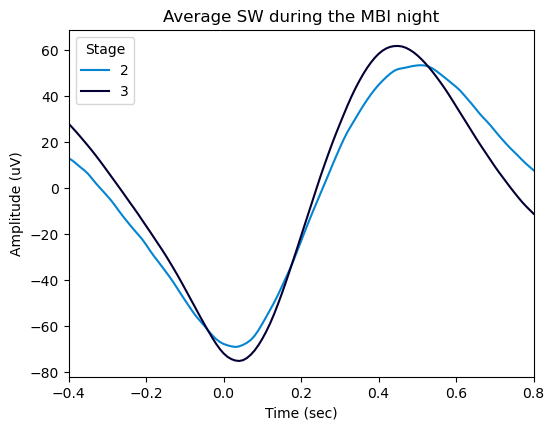

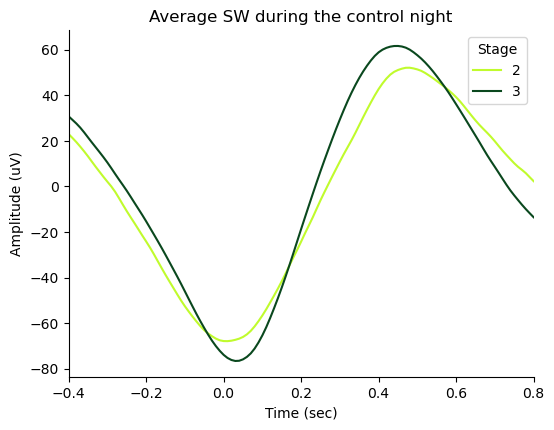

In [40]:
# plot an average template of the detected slow-waves grouped by sleep stage, data source
sw_MBI.plot_average(center="NegPeak", hue="Stage", time_before=0.4, 
                     time_after=0.8, ci=None,
                     palette=["xkcd:cerulean", "xkcd:midnight blue"])
plt.title('Average SW during the MBI night')
sw_control.plot_average(center="NegPeak", hue="Stage", time_before=0.4, 
                     time_after=0.8, ci=None,
                     palette=["xkcd:yellow green", "xkcd:pine green"])
plt.title('Average SW during the control night')
ax.legend(frameon=False)
sns.despine()

### CL-NMES recordings

In [137]:
# get full detection df
sw_CLNMES.summary().round(2)

# get average frequency and duration per channel for each sleep stage
CLNMES_results = sw_CLNMES.summary(grp_chan = True, grp_stage = True)[['Duration', 'Frequency']]

# average the duration for each sleep stage
s2 = CLNMES_results.loc[CLNMES_results.index.get_level_values('Stage') == 2]
s2 = s2.droplevel(0) # remove the first level of the multiindex
s3 = CLNMES_results.loc[CLNMES_results.index.get_level_values('Stage') == 3]
s3 = s3.droplevel(0)

# duration_s2 = CLNMES_results.loc[CLNMES_results.index.get_level_values('Stage') == 2]['Duration']
duration_s2 = s2['Duration']
duration_s3 = s3['Duration']

print(f'The average slow wave duration for the MBI night is {duration_s2.mean():.2f} sec in stage 2 and {duration_s3.mean():.2f} sec in stage 3')

# average frequency for each sleep stage
all_s2_freq = sw_CLNMES.summary()[sw_CLNMES.summary()['Stage'] == 2][['Channel','Frequency']]
freq_s2 = s2['Frequency']
freq_s3 = s3['Frequency']

print(f'The average slow wave frequency for the MBI night is {freq_s2.mean():.2f} Hz in stage 2 and {freq_s3.mean():.2f} Hz in stage 3')

The average slow wave duration for the MBI night is 1.27 sec in stage 2 and 1.12 sec in stage 3
The average slow wave frequency for the MBI night is 0.82 Hz in stage 2 and 0.93 Hz in stage 3


In [151]:
# Create an empty Info object
info = mne.create_info(ch_names=lab_eeg_chans, sfreq=lab_sf, ch_types='eeg')

# Set channel locations (replace with actual coordinates)
info.set_montage('standard_1020')

# Add additional information (e.g., channel types, units, etc.)
info['description'] = 'EEG data'
info['bads'] = []  # List of bad channels (if any)

# Print the Info object
print(info)

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, FC5, FC1, FC2, FC6
 chs: 7 EEG
 custom_ref_applied: False
 description: EEG data
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 128.0 Hz
>


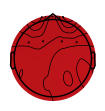

In [156]:
# yasa.topoplot(freq_s2, vlim =(0,1)) # does not work (see GitHub issue)
# yasa.topoplot(all_s2_freq['Frequency'], vmin=0, vmax=1);

mne.viz.plot_topomap(data = freq_s2, pos = info, vlim = (0,1)) #FIXME
plt.show()

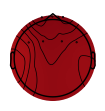

(<matplotlib.image.AxesImage at 0x19d8e8130>,
 <matplotlib.contour.QuadContourSet at 0x19d8e83d0>)

In [157]:
mne.viz.plot_topomap(data = freq_s3, pos = info, vlim = (0,1)) #FIXME

# (d)
Is there a difference in **SO/spindle coupling** between comparable datasets, i.e., mindfulness versus control, Stim vs. Sham in CLNMES

### At-home recordings

In [44]:
# detect co-occurring SW/spindle events
sw_MBI.find_cooccurring_spindles(spindles_MBI.summary(), lookaround=1.2)
sw_MBI.summary()
sw_control.find_cooccurring_spindles(spindles_control.summary(), lookaround=1.2)

# compare number of co-occurring spindles
id_cooccurrence_MBI = sw_MBI.summary()['CooccurringSpindle'] == True
id_cooccurrence_control = sw_control.summary()['CooccurringSpindle'] == True
print(f'During the MBI night, {sum(id_cooccurrence_MBI)/len(id_cooccurrence_MBI):.3f} % of the slow wave events were coupled w/ spindles. (absolute number {sum(id_cooccurrence_MBI):.0f})')
print(f'During the control night, there were {sum(id_cooccurrence_control):.0f} couplings ({sum(id_cooccurrence_control)/len(id_cooccurrence_control):.6f} %)\n')

# distance from center of spindles to negative peak of slow waves
dist_MBI = sw_MBI.summary()['DistanceSpindleToSW'][id_cooccurrence_MBI].mean()
dist_MBI # negative values suggest that spindle is not coupled w/ slow wave
dist_control = sw_MBI.summary()['DistanceSpindleToSW'][id_cooccurrence_control].mean()
#dist_control
print('Average distance between spindle center and negative peak of slow waves:')
print('In the MBI night:', dist_MBI, 'sec\n', 'In the control night:', dist_control, 'sec\n')

# compare mean amplitudes
#sw_MBI.summary()['CooccurringSpindlePeak'].mean()
AvgSOSpindlePeak_MBI = sw_MBI.summary()['CooccurringSpindlePeak'][id_cooccurrence_MBI].mean().round(2)
AvgSOSpindlePeak_control = sw_control.summary()['CooccurringSpindlePeak'][id_cooccurrence_control].mean().round(2)
print('Mean amplitude of spindle that is co-occuring w/ SO in MBI night:', AvgSOSpindlePeak_MBI)
print('In the control night:', AvgSOSpindlePeak_control)


During the MBI night, 0.006 % of the slow wave events were coupled w/ spindles. (absolute number 71)
During the control night, there were 50 couplings (0.004169 %)

Average distance between spindle center and negative peak of slow waves:
In the MBI night: -0.45690140845050004 sec
 In the control night: -0.5100000000002183 sec

Mean amplitude of spindle that is co-occuring w/ SO in MBI night: 11207.06
In the control night: 13686.44


The datasets suggest that slow waves and spindles are more frequently synchronized in the night that involved mindfulness-based practice. This is an interesting preliminary result since SO/spindle coupling is thought to play a role in memory consolidation. However, the average distance from the center of spindles to the negative peak of slow waves is negative, suggesting that seemingly “coupled” spindles occurred before slow waves.

Furthermore, the maximum peak of the spindles associated with slow-waves was higher in the control night data. This suggests that the strength of the phase-amplitude coupling was weaker in the MBI night. (**? FIXME**).

### CL-NMES recordings

In [45]:
# Detect co-occurring SW/spindle events
sw_CLNMES.find_cooccurring_spindles(spindles_CLNMES.summary(), lookaround=1.2)

In [46]:
# compare number of co-occurring spindles
id_cooccurrence_CLNMES = sw_CLNMES.summary()['CooccurringSpindle'] == True
print(f'During the CLNMES night, {sum(id_cooccurrence_CLNMES)/len(id_cooccurrence_CLNMES):.6f} % of the slow wave events were coupled w/ spindles. (absolute number {sum(id_cooccurrence_CLNMES):.0f})\n')


# distance from center of spindles to negative peak of slow waves
dist_CLNMES = sw_CLNMES.summary()['DistanceSpindleToSW'][id_cooccurrence_CLNMES].mean()
 # negative values suggest that spindle is not coupled w/ slow wave
print('Average distance between spindle center and negative peak of slow waves:')
print('In the CLNMES night:', dist_CLNMES, 'sec\n')

# compare mean amplitudes
AvgSOSpindlePeak_CLNMES = sw_CLNMES.summary()['CooccurringSpindlePeak'][id_cooccurrence_CLNMES].mean().round(2)
print('Mean amplitude of spindle that is co-occuring w/ SO in CLNMES night:', AvgSOSpindlePeak_CLNMES)

During the CLNMES night, 0.000320 % of the slow wave events were coupled w/ spindles. (absolute number 3)

Average distance between spindle center and negative peak of slow waves:
In the CLNMES night: 1.0390625 sec

Mean amplitude of spindle that is co-occuring w/ SO in CLNMES night: 5159.87


**TODO:** Interpretation of these results

**TODO** distinguish between sham and stim condition

# Section 3: Analysis of evoked waveforms in CLNMES

# (a)

Extract the evoked waveform associated with CLNMES and compare the response in
Stim versus Sham.

In [48]:
# load the epoched data
epoched_CLNMES = mne.read_epochs(dir + '1-epo.fif', preload = True);
epoched_CLNMES
# nmes trigger value for sham: 12
# nmes trigger value for stim: 9

Number of events,520
Events,classification: 499nmes_sham: 12nmes_stim: 9
Time range,-3.000 – 2.992 s
Baseline,-3.000 – 0.000 s


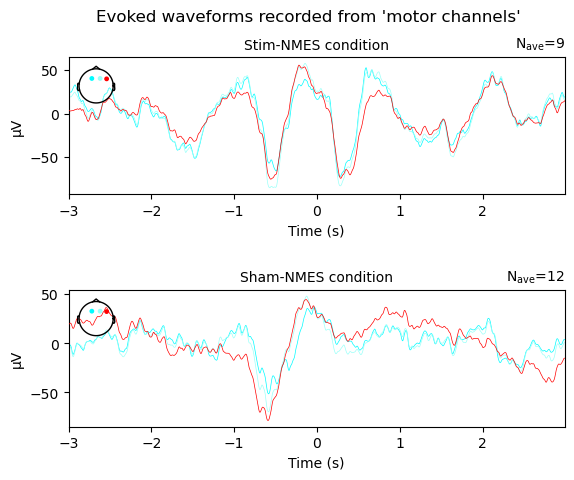

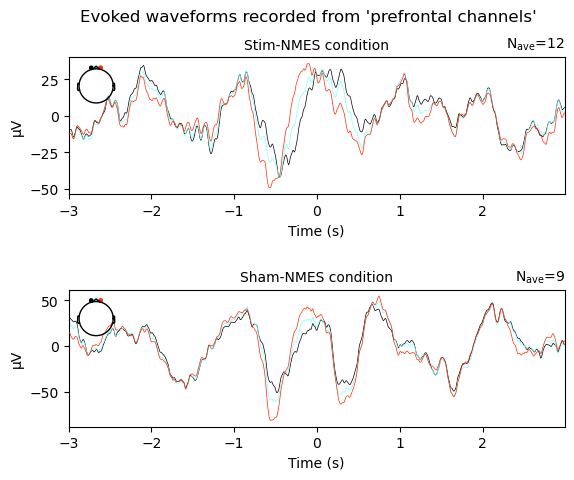

In [49]:
# access data from Stim and Sham condition
epochs_NMES = epoched_CLNMES['nmes_stim'];
epochs_Sham = epoched_CLNMES['nmes_sham'];

# average the data for the "frontal cortex" -> extract evoked waveforms
evoked_stim = epochs_NMES.average();
evoked_sham = epochs_Sham.average();

# plot the evoked waveforms for both conditions
fig, axes = plt.subplots(2, 1);
plt.subplots_adjust(wspace=0.5, hspace=0.7); # increase margin between figures
evoked_stim.plot(picks=lab_motorc_channels, axes=axes[0], show=False);
fig.suptitle("Evoked waveforms recorded from 'motor channels'")
axes[0].set_title("Stim-NMES condition", fontsize =10);
evoked_sham.plot(picks=lab_motorc_channels, axes=axes[1], show=False);
axes[1].set_title("Sham-NMES condition", fontsize=10);
plt.show()

fig, axes = plt.subplots(2, 1);
plt.subplots_adjust(wspace=0.5, hspace=0.7); # increase margin between figures
fig.suptitle("Evoked waveforms recorded from 'prefrontal channels'")
evoked_stim.plot(picks=lab_prefrontal_channels, axes=axes[1], show=False);
evoked_sham.plot(picks=lab_prefrontal_channels, axes=axes[0], show=False);
axes[0].set_title("Stim-NMES condition", fontsize=10);
axes[1].set_title("Sham-NMES condition", fontsize=10);
plt.show()


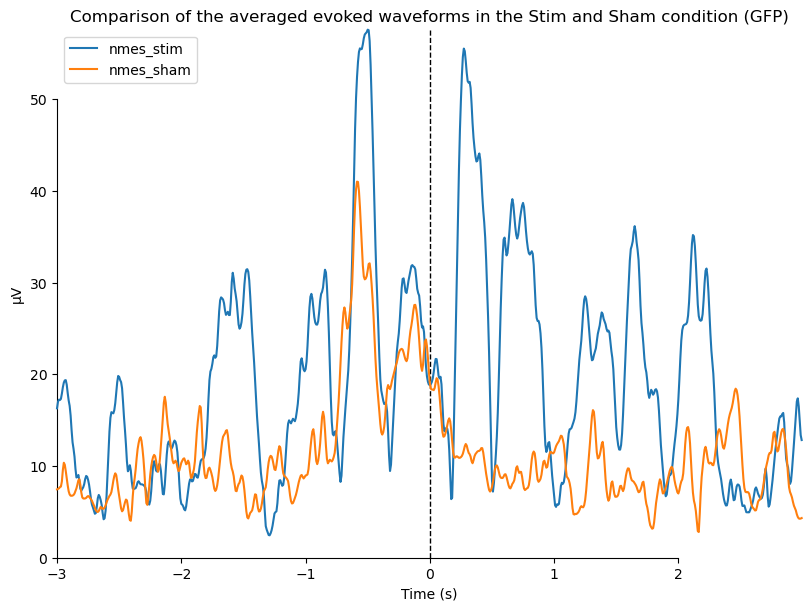

In [50]:
# compare the evoked waveforms
mne.viz.plot_compare_evokeds([evoked_stim, evoked_sham],
                             title="Comparison of the averaged evoked waveforms in the Stim and Sham condition");

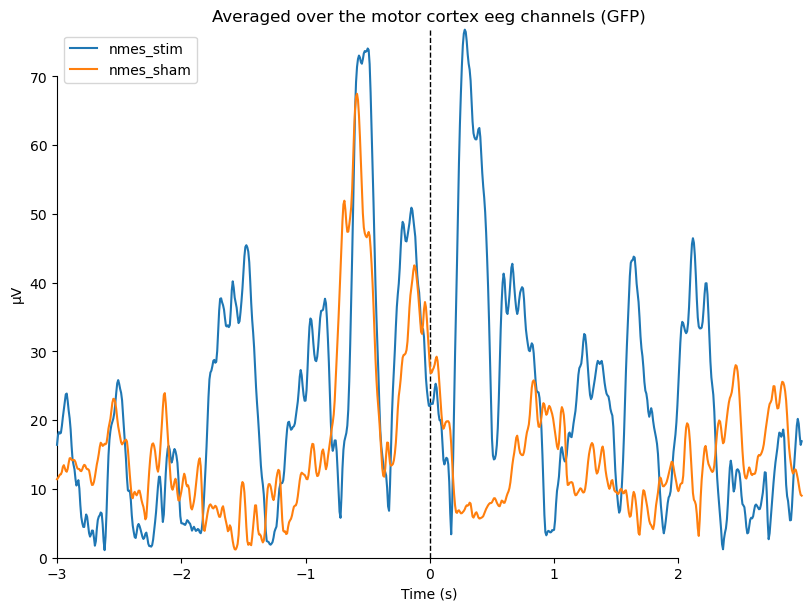

In [51]:
# compare evoked waveforms for channels above the motor cortex
mne.viz.plot_compare_evokeds([evoked_stim, evoked_sham],
                             title="Averaged over the motor cortex eeg channels", 
                             picks= lab_motorc_channels);

As expected, averaged postsynaptic potentials measured above the motor cortex are much more pronounced in the Stim-Condtion compared to the Sham-Condition. 

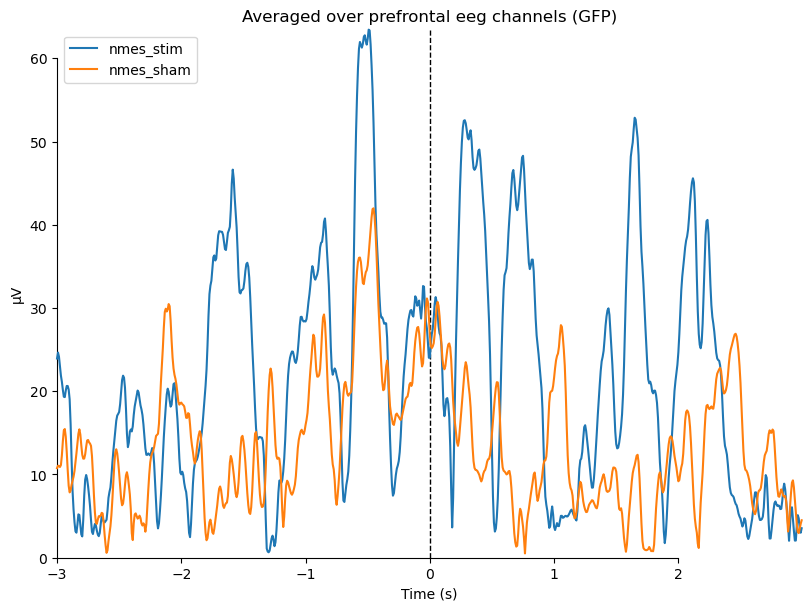

In [52]:
# compare evoked waveforms for prefrontal channels
mne.viz.plot_compare_evokeds([evoked_stim, evoked_sham],
                             title="Averaged over prefrontal eeg channels", 
                             picks= lab_prefrontal_channels);

# (b)

Compute the power differences between Stim and Sham

In [56]:
# estimate the spectral densities for the Stim condition using the Welch method
psd_stim = epochs_NMES.compute_psd(method = 'welch', fmin=0.5, fmax = 40, # frequency range of interest: [0.5,40] Hz
                                   picks = lab_eeg_chans, 
                                   **dict(average='median', n_fft=int((2/0.5)*lab_sf)));

# do the same for sham
psd_sham = epochs_Sham.compute_psd(method = 'welch', fmin=0.5, fmax = 40, picks = lab_eeg_chans,
                                     **dict(average='median', n_fft=int((2/0.5)*lab_sf)));

# get the averaged data
psds_stim, freqs_stim = psd_stim.average().get_data(return_freqs=True);
psds_sham, freqs_sham = psd_sham.average().get_data(return_freqs = True);


#print(psds_stim.shape)
#print(freqs_stim.shape)
assert all(freqs_stim == freqs_sham)

# compute the difference
psds_diff = psds_stim - psds_sham;
psds_diff;


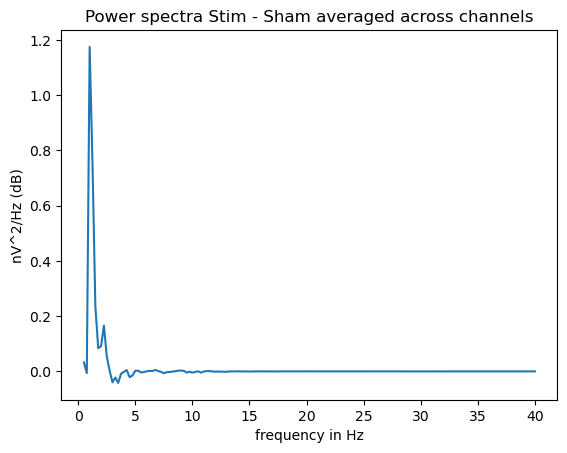

In [55]:
# average the difference over all channels
avg_diff = psds_diff[:7].mean(axis=0);

# plot the power differences
plt.plot(freqs_stim, avg_diff*10**9)
plt.xlabel("frequency in Hz")
plt.ylabel("nV^2/Hz (dB)")
plt.title("Power spectra Stim - Sham averaged across channels");